> # **Wrangling the MyAnimeList dataset**
> ## **by Tevin Aduma**

> ## Introduction
>
> This is the initial notebook used to clean the MAL datasets to fit the model required for further exploration and explanatory visualizations.


In [49]:
from textblob import TextBlob

import unittest

import pandas as pd
import numpy as np
import re

#ensure all Plotly plots render while offline
import matplotlib.pyplot as plt
import seaborn as sb

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import plotly.express as px

init_notebook_mode(connected=True)

%matplotlib inline

> Importing required libraries and modules

#### <hr>
> 
> Loading the datasets

In [50]:
#custom function to read data into Pandas DataFrame
def open_set(csv, sep=','):
    df = pd.read_csv(csv, low_memory=False)
    
    return df

In [52]:
df_animes = open_set('../data/animes.csv') 
df_reviews = open_set('../data/reviews.csv')

## Animes dataset

In [53]:
df_animes

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ..."
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14473,26089,Gutchonpa Omoshiro Hanashi,NaN,グッチョンパおもしろ話,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Unknown,5,Finished Airing,...,NaN,Fall 1987,Unknown,"{'Other': [{'mal_id': 26087, 'type': 'anime', ...",NaN,NaN,NaN,Kids,[],[]
14474,21525,Geba Geba Shou Time!,NaN,ゲバゲバ笑タイム!,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Unknown,1,Finished Airing,...,NaN,NaN,NaN,[],Studio Lotus,NaN,NaN,Comedy,[],[]
14475,37897,Godzilla: Hoshi wo Kuu Mono,NaN,GODZILLA -星を喰う者-,"Godzilla Part 3, Godzilla: Eater of Stars",https://myanimelist.cdn-dena.com/images/anime/...,Movie,Other,1,Not yet aired,...,NaN,NaN,NaN,"{'Prequel': [{'mal_id': 36816, 'type': 'anime'...",NaN,NaN,NaN,"Action, Sci-Fi, Adventure, Fantasy",[],[]
14476,34193,Nippon Mukashibanashi: Sannen Netarou,NaN,日本昔ばなし 三ねん寝太郎,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Other,1,Finished Airing,...,NaN,NaN,NaN,[],NaN,NaN,NaN,"Fantasy, Kids",[],[]


In [54]:
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14478 entries, 0 to 14477
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        14478 non-null  int64  
 1   title           14478 non-null  object 
 2   title_english   5724 non-null   object 
 3   title_japanese  14443 non-null  object 
 4   title_synonyms  8937 non-null   object 
 5   image_url       14382 non-null  object 
 6   type            14478 non-null  object 
 7   source          14478 non-null  object 
 8   episodes        14478 non-null  int64  
 9   status          14478 non-null  object 
 10  airing          14478 non-null  bool   
 11  aired_string    14478 non-null  object 
 12  aired           14478 non-null  object 
 13  duration        14478 non-null  object 
 14  rating          14478 non-null  object 
 15  score           14478 non-null  float64
 16  scored_by       14478 non-null  int64  
 17  rank            12904 non-null 

#### Wrangling Steps Required

> * The **aired** will have to be engineered to contain only the start date of the anime listings.
>
> * Certain datatypes will have to be changed pertaining to dates, string types and float to ints.
>
> * A number of unrequired columns will be dropped from the dataset; these will not be required in this study i.e. **opening_theme**, **ending_theme**
>
> * Due to the volume of records in this dataset, I will use what I consider to be relevant for this study. Records of anime aired from 1992 to 2018 due to a sense of recency in the trends of the anime industry.
>
> * Dropping all records with any null values will be of utter importance. 
>
> * Feature engineering required for a new column that will capture what **season** the anime was released in. I will use a custom function to generate this information.
>
> * Split the data in the **Genre** column to capture the first stated genre as the main theme of the anime listings.
>
> * Engineer new **ranking** columns based on the volume of **favorites**, **popularity** and **members** for each listing. I will also create a new column that encapsulates the other three ranks on an average scale i.e. **avg_rank_score**

<hr>

#### Obtaining the inital `air date` by splitting the `aired` column

In [1]:
# here I will split the column by a single apostrophe as is the format the data was captured in

df_animes.aired = df_animes.aired.apply(lambda x: x.split("'")[3])

NameError: name 'df_animes' is not defined

In [56]:
df_animes.aired

0        2012-01-13
1        2007-04-02
2        2008-10-04
3        2002-08-16
4        2012-10-06
            ...    
14473    1987-11-05
14474    1986-03-21
14475            to
14476            to
14477    2010-04-07
Name: aired, Length: 14478, dtype: object

> * Records that seem to have only the word **'to'** did not have air dates set. These records will be dropped as they will not reflect insights in ant time series analysis.

<hr>

#### Converting the `aired` column to `datetime datatype`

In [57]:
# use the 'coerce' mode to skip over any non-datetime-like entires such as records with 'to' in their aired column
df_animes.aired = pd.to_datetime(df_animes.aired, 'coerce')

In [58]:
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14478 entries, 0 to 14477
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   anime_id        14478 non-null  int64         
 1   title           14478 non-null  object        
 2   title_english   5724 non-null   object        
 3   title_japanese  14443 non-null  object        
 4   title_synonyms  8937 non-null   object        
 5   image_url       14382 non-null  object        
 6   type            14478 non-null  object        
 7   source          14478 non-null  object        
 8   episodes        14478 non-null  int64         
 9   status          14478 non-null  object        
 10  airing          14478 non-null  bool          
 11  aired_string    14478 non-null  object        
 12  aired           12787 non-null  datetime64[ns]
 13  duration        14478 non-null  object        
 14  rating          14478 non-null  object        
 15  sc

> * Successfully been able to convert the elgible datetypes to datetime datatype.

<hr>

#### Filtering to obtain only anime listings prodiced between 1992 and 2018

In [59]:
df_animes = df_animes.query("'1991-12-31' < aired < '2018-12-31'")
df_animes

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ..."
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14463,37787,Space Bug,NaN,スペースバグ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,0,Not yet aired,...,NaN,Summer 2018,Sundays at 10:30 (JST),[],NaN,NaN,NaN,"Adventure, Space",[],[]
14464,35229,Mr. Men Little Miss,Mr. Men Little Miss,Mr. Men Little Miss / ミスターメン リトルミス,NaN,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Picture book,0,Currently Airing,...,NaN,NaN,NaN,[],NaN,NaN,Sanrio,Kids,[],[]
14465,27579,Mii-chan no Tenohira,NaN,みいちゃんのてのひら,NaN,https://myanimelist.cdn-dena.com/images/anime/...,Movie,Unknown,1,Finished Airing,...,NaN,NaN,NaN,[],Magic Bus,NaN,NaN,"Historical, Drama",[],[]
14466,36640,Mashiro Witch,Mashiro Witch - Midnight Marchen,ましろウィッチ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Game,1,Finished Airing,...,NaN,NaN,NaN,[],NaN,NaN,NaN,"Game, Magic",[],[]


In [60]:
df_animes.reset_index(inplace=True)
df_animes.drop(columns=['index'], inplace=True)

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\3279013695.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<hr>

In [61]:
df_animes.aired = pd.to_datetime(df_animes.aired, 'coerce').dt.date
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10833 entries, 0 to 10832
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        10833 non-null  int64  
 1   title           10833 non-null  object 
 2   title_english   4564 non-null   object 
 3   title_japanese  10812 non-null  object 
 4   title_synonyms  6759 non-null   object 
 5   image_url       10823 non-null  object 
 6   type            10833 non-null  object 
 7   source          10833 non-null  object 
 8   episodes        10833 non-null  int64  
 9   status          10833 non-null  object 
 10  airing          10833 non-null  bool   
 11  aired_string    10833 non-null  object 
 12  aired           10833 non-null  object 
 13  duration        10833 non-null  object 
 14  rating          10833 non-null  object 
 15  score           10833 non-null  float64
 16  scored_by       10833 non-null  int64  
 17  rank            9473 non-null  

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\890020244.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Generating season release data based on the month of the year

In [2]:
# custom function to generate the season the anime listings were released in based on their month of release. 

def premiered(x):
    year = x.year
    month = x.month
    if month in [3,4,5]:
        premiere = f'Spring {year}'
    elif month in [6,7,8]:
        premiere = f'Summer {year}'
    elif month in [9,10,11]:
        premiere = f'Fall {year}'
    elif month in [1,2,12]:
        premiere = f'Winter {year}'
    return premiere

    


In [ ]:
df_animes['premiered'] = df_animes.aired.apply(lambda x: premiered(x))

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\2728417715.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_animes.premiered

0        Winter 2012
1        Spring 2007
2          Fall 2008
3        Summer 2002
4          Fall 2012
            ...     
10828    Summer 2018
10829      Fall 2013
10830    Spring 1993
10831    Spring 2017
10832    Spring 2010
Name: premiered, Length: 10833, dtype: object

> * As seen, I've been able to generate the seasonal release period for each anime listing by applying the custom function.

<hr>

#### I will also split the data in the new `premiered` feature to capture what year and season these listings were released in.

In [ ]:
df_animes['season_released'] = df_animes.premiered.apply( lambda x: x.split()[0])
df_animes['year_released'] = df_animes.premiered.apply( lambda x: x.split()[1])

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\313155746.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\313155746.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_animes['season_released']

0        Winter
1        Spring
2          Fall
3        Summer
4          Fall
          ...  
10828    Summer
10829      Fall
10830    Spring
10831    Spring
10832    Spring
Name: season_released, Length: 10833, dtype: object

In [ ]:
df_animes['year_released']

0        2012
1        2007
2        2008
3        2002
4        2012
         ... 
10828    2018
10829    2013
10830    1993
10831    2017
10832    2010
Name: year_released, Length: 10833, dtype: object

<hr>

#### Dropping features unrequired for a deeper study of the MAL dataset

In [69]:
df_animes.columns

Index(['anime_id', 'title', 'title_english', 'title_japanese',
       'title_synonyms', 'image_url', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'rating', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'favorites', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studio',
       'genre', 'opening_theme', 'ending_theme', 'season_released',
       'year_released'],
      dtype='object')

In [70]:
df_animes.drop(columns=['title_english', 'title_japanese','title_synonyms',
                        'airing', 'aired_string', 'aired', 'background', 'broadcast',
                        'related', 'producer', 'licensor', 'opening_theme', 'ending_theme'],
                        inplace=True)

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\3637861433.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_animes.columns

* > I have managed to obtained a less noisy dataset with only interesting features to investigate.

<hr>

#### Dropping records with null entries

In [75]:
df_animes.dropna(subset=['genre', 'studio'], inplace=True)
df_animes.reset_index(inplace=True)
df_animes.drop(columns='index', inplace=True)
df_animes.sample(7)

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\1761615526.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\1761615526.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,anime_id,title,season_released,year_released,type,source,genre,studio,episodes,status,premiered,rank,members,favorites,popularity,rating,score,scored_by,image_url
550,33480,Waku Waku Koma-chan,Summer,2016,ONA,Original,"Adventure, Kids",dwarf,1,Finished Airing,Summer 2016,12628.0,69,0,13653,G - All Ages,4.00,3,https://myanimelist.cdn-dena.com/images/anime/...
281,35889,Hakata Tonkotsu Ramens,Winter,2018,TV,Novel,Action,Satelight,12,Finished Airing,Winter 2018,1461.0,69028,235,1189,R - 17+ (violence & profanity),7.56,22487,https://myanimelist.cdn-dena.com/images/anime/...
6088,16436,Tenshi no Drop,Spring,2013,Special,Web manga,"Comedy, Ecchi, Shounen",AIC Frontier,1,Finished Airing,Spring 2013,9475.0,8732,8,3892,R - 17+ (violence & profanity),3.69,5476,https://myanimelist.cdn-dena.com/images/anime/...
6664,1362,Street Fighter II Movie,Summer,1994,Movie,Game,"Action, Martial Arts, Shounen",Group TAC,1,Finished Airing,Summer 1994,2629.0,18162,99,2796,PG-13 - Teens 13 or older,7.25,12155,https://myanimelist.cdn-dena.com/images/anime/...
4,12365,Bakuman. 3rd Season,Fall,2012,TV,Manga,"Comedy, Drama, Romance, Shounen",J.C.Staff,25,Finished Airing,Fall 2012,50.0,182765,2082,426,PG-13 - Teens 13 or older,8.67,107767,https://myanimelist.cdn-dena.com/images/anime/...
945,8493,Gegege no Kitarou: Kitarou no Yuurei Densha,Spring,1999,Movie,Unknown,"Adventure, Super Power, Demons, Supernatural",Toei Animation,1,Finished Airing,Spring 1999,7459.0,332,0,10282,G - All Ages,5.95,68,https://myanimelist.cdn-dena.com/images/anime/...
3737,30364,Haikyuu!! Movie 2: Shousha to Haisha,Fall,2015,Movie,Manga,"Comedy, Sports, Drama, School, Shounen",Production I.G,1,Finished Airing,Fall 2015,567.0,19367,25,2715,None,7.99,4051,https://myanimelist.cdn-dena.com/images/anime/...


In [ ]:
df_animes.info()

#### Capturing the main theme of each listing with the first record in the **Genre** column

In [77]:
df_animes.genre = df_animes.genre.apply(lambda x: x.split(',',1)[0])
df_animes.sample(6)

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\1432982469.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,anime_id,title,season_released,year_released,type,source,genre,studio,episodes,status,premiered,rank,members,favorites,popularity,rating,score,scored_by,image_url
795,5419,Paniponi Dash!: Danjite Okonaeba Kishin mo Kor...,Spring,2009,Special,Manga,Parody,Shaft,1,Finished Airing,Spring 2009,1310.0,7533,3,4142,PG-13 - Teens 13 or older,7.62,3642,https://myanimelist.cdn-dena.com/images/anime/...
476,35677,Liz to Aoi Tori,Spring,2018,Movie,Novel,Music,Kyoto Animation,1,Finished Airing,Spring 2018,1530.0,13838,24,3214,PG-13 - Teens 13 or older,7.54,89,https://myanimelist.cdn-dena.com/images/anime/...
2507,32309,Tabi Machi Late Show,Winter,2016,TV,Original,Slice of Life,CoMix Wave Films,4,Finished Airing,Winter 2016,6598.0,6688,6,4333,PG - Children,6.25,3561,https://myanimelist.cdn-dena.com/images/anime/...
1495,34888,Makeruna!! Aku no Gundan!,Spring,2017,TV,Manga,Comedy,Tatsunoko Production,12,Finished Airing,Spring 2017,8672.0,1307,1,7733,None,5.31,506,https://myanimelist.cdn-dena.com/images/anime/...
1509,34863,Zoku Touken Ranbu: Hanamaru,Winter,2018,TV,Card game,Action,Doga Kobo,12,Finished Airing,Winter 2018,2140.0,14213,76,3170,PG-13 - Teens 13 or older,7.38,2663,https://myanimelist.cdn-dena.com/images/anime/...
125,10197,Nyanpire The Animation,Summer,2011,TV,Manga,Comedy,Gonzo,12,Finished Airing,Summer 2011,4413.0,21460,83,2572,G - All Ages,6.78,11034,https://myanimelist.cdn-dena.com/images/anime/...


<hr>

#### Generating rankings based on popularity and MAL's scores

Text(0.5, 1.0, 'Correlation Between Ranking Features of Anime')

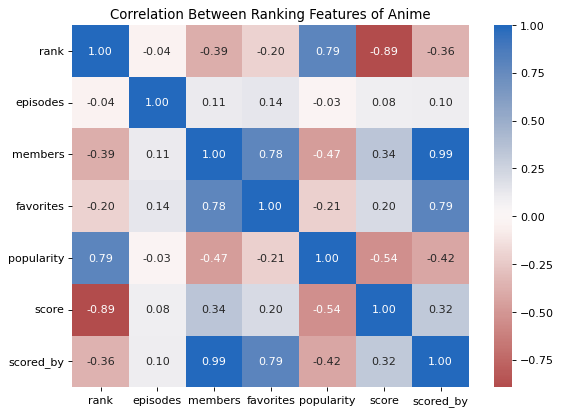

In [78]:
plt.figure(figsize=(8, 6), dpi=80)
fig = sb.heatmap(df_animes[['rank', 'episodes', 'members', 'favorites','popularity', 'rating', 'score', 'scored_by']].corr(), annot=True, fmt='.2f', cmap='vlag_r', center=0)
plt.title('Correlation Between Ranking Features of Anime')

In [79]:
df_animes['score_rank'] = df_animes['score'].rank(method='dense', ascending=False)
df_animes['popularity_rank'] = df_animes['popularity'].rank(method='dense', ascending=True)
df_animes['avg_rank_score'] = (df_animes.score_rank + df_animes.popularity_rank)/2
df_animes['rank'] = df_animes.avg_rank_score.rank(method='min')
df_animes

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\210410646.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\210410646.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\210410646.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,anime_id,title,season_released,year_released,type,source,genre,studio,episodes,status,...,members,favorites,popularity,rating,score,scored_by,image_url,score_rank,popularity_rank,avg_rank_score
0,11013,Inu x Boku SS,Winter,2012,TV,Manga,Comedy,David Production,12,Finished Airing,...,283882,2809,231,PG-13 - Teens 13 or older,7.63,139250,https://myanimelist.cdn-dena.com/images/anime/...,133.0,212.0,172.5
1,2104,Seto no Hanayome,Spring,2007,TV,Manga,Comedy,Gonzo,26,Finished Airing,...,204003,2579,366,PG-13 - Teens 13 or older,7.89,91206,https://myanimelist.cdn-dena.com/images/anime/...,107.0,326.0,216.5
2,5262,Shugo Chara!! Doki,Fall,2008,TV,Manga,Comedy,Satelight,51,Finished Airing,...,70127,802,1173,PG - Children,7.55,37129,https://myanimelist.cdn-dena.com/images/anime/...,141.0,1009.0,575.0
3,721,Princess Tutu,Summer,2002,TV,Original,Comedy,Hal Film Maker,38,Finished Airing,...,93312,3344,916,PG-13 - Teens 13 or older,8.21,36501,https://myanimelist.cdn-dena.com/images/anime/...,75.0,794.0,434.5
4,12365,Bakuman. 3rd Season,Fall,2012,TV,Manga,Comedy,J.C.Staff,25,Finished Airing,...,182765,2082,426,PG-13 - Teens 13 or older,8.67,107767,https://myanimelist.cdn-dena.com/images/anime/...,31.0,381.0,206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7153,37428,Chara to Otamajakushi Shima,Spring,2018,TV,Original,Adventure,33 Collective,0,Currently Airing,...,21,0,14456,G - All Ages,0.00,0,https://myanimelist.cdn-dena.com/images/anime/...,510.0,6231.0,3370.5
7154,37577,Hibike! Euphonium Movie: Todoketai Melody - Ph...,Fall,2017,Movie,Unknown,Comedy,Kyoto Animation,3,Finished Airing,...,809,1,8789,PG-13 - Teens 13 or older,5.66,35,https://myanimelist.cdn-dena.com/images/anime/...,330.0,5231.0,2780.5
7155,28113,Ooi! Adacchii!,Winter,1992,OVA,Unknown,Kids,Mushi Production,1,Finished Airing,...,83,0,13462,G - All Ages,5.78,9,https://myanimelist.cdn-dena.com/images/anime/...,318.0,6153.0,3235.5
7156,35229,Mr. Men Little Miss,Fall,2013,ONA,Picture book,Kids,Sanrio,0,Currently Airing,...,49,1,14066,G - All Ages,4.57,7,https://myanimelist.cdn-dena.com/images/anime/...,432.0,6216.0,3324.0


#### Reshaping the dataframe

In [80]:
df_animes = df_animes[['anime_id', 'title', 'genre', 'studio', 'season_released','year_released', 'type', 'source',
                        'episodes', 'status', 'rank', 'image_url','rating', 'score', 'scored_by', 'score_rank',
                        'popularity','popularity_rank','members', 'favorites', 'avg_rank_score']]

In [81]:
df_animes['rank'] = df_animes['rank'].apply(int)
df_animes

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\3687278349.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,anime_id,title,genre,studio,season_released,year_released,type,source,episodes,status,...,image_url,rating,score,scored_by,score_rank,popularity,popularity_rank,members,favorites,avg_rank_score
0,11013,Inu x Boku SS,Comedy,David Production,Winter,2012,TV,Manga,12,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,7.63,139250,133.0,231,212.0,283882,2809,172.5
1,2104,Seto no Hanayome,Comedy,Gonzo,Spring,2007,TV,Manga,26,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,7.89,91206,107.0,366,326.0,204003,2579,216.5
2,5262,Shugo Chara!! Doki,Comedy,Satelight,Fall,2008,TV,Manga,51,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG - Children,7.55,37129,141.0,1173,1009.0,70127,802,575.0
3,721,Princess Tutu,Comedy,Hal Film Maker,Summer,2002,TV,Original,38,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,8.21,36501,75.0,916,794.0,93312,3344,434.5
4,12365,Bakuman. 3rd Season,Comedy,J.C.Staff,Fall,2012,TV,Manga,25,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,8.67,107767,31.0,426,381.0,182765,2082,206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7153,37428,Chara to Otamajakushi Shima,Adventure,33 Collective,Spring,2018,TV,Original,0,Currently Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,G - All Ages,0.00,0,510.0,14456,6231.0,21,0,3370.5
7154,37577,Hibike! Euphonium Movie: Todoketai Melody - Ph...,Comedy,Kyoto Animation,Fall,2017,Movie,Unknown,3,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,5.66,35,330.0,8789,5231.0,809,1,2780.5
7155,28113,Ooi! Adacchii!,Kids,Mushi Production,Winter,1992,OVA,Unknown,1,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,G - All Ages,5.78,9,318.0,13462,6153.0,83,0,3235.5
7156,35229,Mr. Men Little Miss,Kids,Sanrio,Fall,2013,ONA,Picture book,0,Currently Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,G - All Ages,4.57,7,432.0,14066,6216.0,49,1,3324.0


In [82]:
df_animes['rank'].describe()

count    7158.000000
mean     3578.956133
std      2066.491127
min         1.000000
25%      1790.000000
50%      3579.500000
75%      5368.000000
max      7158.000000
Name: rank, dtype: float64

#### Sort values in the dataframe based on the rank values

In [83]:
df_animes.sort_values('rank', ascending=True, inplace=True)

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\4231205889.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [84]:
df_animes

,anime_id,title,genre,studio,season_released,year_released,type,source,episodes,status,...,image_url,rating,score,scored_by,score_rank,popularity,popularity_rank,members,favorites,avg_rank_score
1356,5114,Fullmetal Alchemist: Brotherhood,Action,Bones,Spring,2009,TV,Manga,64,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,R - 17+ (violence & profanity),9.25,733592,2.0,4,4.0,1199091,106895,3.0
1590,9253,Steins;Gate,Thriller,White Fox,Spring,2011,TV,Visual novel,24,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,9.14,563857,5.0,8,8.0,1010330,92423,6.5
7046,1575,Code Geass: Hangyaku no Lelouch,Action,Sunrise,Fall,2006,TV,Original,25,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,R - 17+ (violence & profanity),8.79,627740,22.0,9,9.0,986897,63614,15.5
4528,30276,One Punch Man,Action,Madhouse,Fall,2015,TV,Web manga,12,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,R - 17+ (violence & profanity),8.73,691845,27.0,5,5.0,1020754,30747,16.0
4086,1535,Death Note,Mystery,Madhouse,Fall,2006,TV,Manga,37,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,R - 17+ (violence & profanity),8.67,1009477,31.0,1,1.0,1456378,88696,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7133,37858,Free! Movie 1: Timeless Medley - Kizuna: Chara...,Comedy,Kyoto Animation,Spring,2017,Movie,Original,4,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,0.00,0,510.0,14425,6227.0,298,0,3368.5
7128,37859,Free! Movie 2: Timeless Medley - Yakusoku: Cha...,Comedy,Kyoto Animation,Summer,2017,Movie,Original,4,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,0.00,0,510.0,14426,6228.0,261,0,3369.0
7122,37860,Free!: Take Your Marks: Character Butai Aisatsu,Comedy,Kyoto Animation,Fall,2017,Movie,Original,4,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,PG-13 - Teens 13 or older,0.00,0,510.0,14427,6229.0,364,0,3369.5
7112,37814,Inazuma Eleven Reloaded: Reformation of Soccer,Sports,OLM,Winter,2018,Special,Game,1,Finished Airing,...,https://myanimelist.cdn-dena.com/images/anime/...,G - All Ages,0.00,0,510.0,14429,6230.0,610,0,3370.0


In [87]:
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7158 entries, 1356 to 7153
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         7158 non-null   int64  
 1   title            7158 non-null   object 
 2   genre            7158 non-null   object 
 3   studio           7158 non-null   object 
 4   season_released  7158 non-null   object 
 5   year_released    7158 non-null   object 
 6   type             7158 non-null   object 
 7   source           7158 non-null   object 
 8   episodes         7158 non-null   int64  
 9   status           7158 non-null   object 
 10  rank             7158 non-null   int64  
 11  image_url        7157 non-null   object 
 12  rating           7158 non-null   object 
 13  score            7158 non-null   float64
 14  scored_by        7158 non-null   int64  
 15  score_rank       7158 non-null   float64
 16  popularity       7158 non-null   int64  
 17  popularity_

#### Saving the dataframe

In [88]:
df_animes.to_csv('data/animes_cleaned.csv', index=False)

<hr>

## Reviews dataset

In [89]:
df_reviews

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149
...,...,...,...,...,...,...,...
192107,240067,Unicorn819,1281,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '5', 'Animation': '1...",https://myanimelist.net/reviews.php?id=240067
192108,285777,ShizzoSVH,1281,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=285777
192109,286904,AlluMan96,1281,\n \n \n \n ...,3,"{'Overall': '3', 'Story': '3', 'Animation': '1...",https://myanimelist.net/reviews.php?id=286904
192110,287903,AgentK300,1281,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '3', 'Animation': '...",https://myanimelist.net/reviews.php?id=287903


In [90]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192112 entries, 0 to 192111
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uid        192112 non-null  int64 
 1   profile    192112 non-null  object
 2   anime_uid  192112 non-null  int64 
 3   text       192112 non-null  object
 4   score      192112 non-null  int64 
 5   scores     192112 non-null  object
 6   link       192112 non-null  object
dtypes: int64(3), object(4)
memory usage: 10.3+ MB


In [92]:
df_reviews.rename(columns={'anime_uid':'anime_id'}, inplace=True)

In [94]:
def merger(df1, df2, using, right=None):
    df1 = pd.merge(df1, df2[right], on=using)
    return df1

df_reviews = merger(df_reviews, df_animes, using='anime_id', right=['anime_id', 'title'])
df_reviews

,uid,profile,anime_id,text,score,scores,link,title_x,title_y
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938,Gintama.,Gintama.
1,249891,claudinou,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '7', 'Animation': '8...",https://myanimelist.net/reviews.php?id=249891,Gintama.,Gintama.
2,313501,PeterFromRussia,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=313501,Gintama.,Gintama.
3,317041,TheGostoso,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=317041,Gintama.,Gintama.
4,245369,Theliel,34096,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '10', 'Animation': '...",https://myanimelist.net/reviews.php?id=245369,Gintama.,Gintama.
...,...,...,...,...,...,...,...,...,...
171330,233376,Kuromizue,9751,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '8...",https://myanimelist.net/reviews.php?id=233376,Strike Witches Movie,Strike Witches Movie
171331,77077,ryanxwonbin,9751,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '7', 'Animation': '8...",https://myanimelist.net/reviews.php?id=77077,Strike Witches Movie,Strike Witches Movie
171332,231781,AobaSuzukaze,9751,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '0', 'Animation': '...",https://myanimelist.net/reviews.php?id=231781,Strike Witches Movie,Strike Witches Movie
171333,78776,7jaws7,9751,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=78776,Strike Witches Movie,Strike Witches Movie


In [ ]:
def index_filter(df, col, avg):
    s = df[col].value_counts()
    s = s.where(s >= avg)
    s.dropna(inplace=True)
    s = pd.DataFrame(s.index)
    s.reset_index(inplace=True)
    s.rename(columns={0:col}, inplace=True)
    df = pd.merge(df, s, how='inner', on=col)
    df.drop(columns='index', inplace=True)
    return df

In [95]:
df_reviews = index_filter(df_reviews, col='anime_id', avg=50)
df_reviews

,uid,profile,anime_id,text,score,scores,link,title_x,title_y
0,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117,Made in Abyss,Made in Abyss
1,259091,Eanki,34599,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '0', 'Animation': '0...",https://myanimelist.net/reviews.php?id=259091,Made in Abyss,Made in Abyss
2,259195,NekoKyupi,34599,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '1...",https://myanimelist.net/reviews.php?id=259195,Made in Abyss,Made in Abyss
3,260193,SmokyChip,34599,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '10', 'Animation': '...",https://myanimelist.net/reviews.php?id=260193,Made in Abyss,Made in Abyss
4,260524,summitsama,34599,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '1...",https://myanimelist.net/reviews.php?id=260524,Made in Abyss,Made in Abyss
...,...,...,...,...,...,...,...,...,...
125860,306903,MrSwashy,8676,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '8', 'Animation': '6...",https://myanimelist.net/reviews.php?id=306903,Amagami SS,Amagami SS
125861,28768,Sheiya,8676,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=28768,Amagami SS,Amagami SS
125862,186416,highpriest2500,8676,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=186416,Amagami SS,Amagami SS
125863,29103,Samurai_Wolf337,8676,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=29103,Amagami SS,Amagami SS


In [96]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125865 entries, 0 to 125864
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   uid       125865 non-null  int64 
 1   profile   125865 non-null  object
 2   anime_id  125865 non-null  int64 
 3   text      125865 non-null  object
 4   score     125865 non-null  int64 
 5   scores    125865 non-null  object
 6   link      125865 non-null  object
 7   title_x   125865 non-null  object
 8   title_y   125865 non-null  object
dtypes: int64(3), object(6)
memory usage: 9.6+ MB


In [97]:

def splitter(df):
    df['Overall'] = (df.scores.str.split("'", expand=True)[3]).astype(int)
    df['Story'] = df.scores.str.split("'", expand=True)[7].astype(int)
    df['Animation'] = df.scores.str.split("'", expand=True)[11].astype(int)
    df['Music'] = df.scores.str.split("'", expand=True)[15].astype(int)
    df['Character Development'] = df.scores.str.split("'", expand=True)[19].astype(int)
    df['Enjoyment'] = df.scores.str.split("'", expand=True)[23].astype(int)

In [98]:
splitter(df_reviews)
df_reviews

,uid,profile,anime_id,text,score,scores,link,title_x,title_y,Overall,Story,Animation,Music,Character Development,Enjoyment
0,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117,Made in Abyss,Made in Abyss,10,10,10,10,10,10
1,259091,Eanki,34599,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '0', 'Animation': '0...",https://myanimelist.net/reviews.php?id=259091,Made in Abyss,Made in Abyss,8,0,0,0,0,0
2,259195,NekoKyupi,34599,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '1...",https://myanimelist.net/reviews.php?id=259195,Made in Abyss,Made in Abyss,9,9,10,9,9,10
3,260193,SmokyChip,34599,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '10', 'Animation': '...",https://myanimelist.net/reviews.php?id=260193,Made in Abyss,Made in Abyss,9,10,10,10,8,9
4,260524,summitsama,34599,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '1...",https://myanimelist.net/reviews.php?id=260524,Made in Abyss,Made in Abyss,7,7,10,10,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125860,306903,MrSwashy,8676,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '8', 'Animation': '6...",https://myanimelist.net/reviews.php?id=306903,Amagami SS,Amagami SS,9,8,6,7,9,9
125861,28768,Sheiya,8676,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=28768,Amagami SS,Amagami SS,8,8,8,8,8,9
125862,186416,highpriest2500,8676,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=186416,Amagami SS,Amagami SS,8,7,9,9,8,8
125863,29103,Samurai_Wolf337,8676,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=29103,Amagami SS,Amagami SS,9,9,9,9,9,9


In [99]:
df_reviews.drop(columns=['uid', 'profile', 'link', 'scores', 'score'], inplace=True)

In [109]:
df_reviews['Overall'] = df_reviews.iloc[:, 3:7].mean(axis=1).round(2)

C:\Users\TEVIN\AppData\Local\Temp\ipykernel_17080\2425714701.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [110]:
df_reviews.head()

,anime_id,text,title_x,title_y,Overall,Story,Animation,Music,Character Development,Enjoyment
0,34599,\n \n \n \n ...,Made in Abyss,Made in Abyss,10.00,10,10,10,10,10
1,34599,\n \n \n \n ...,Made in Abyss,Made in Abyss,0.00,0,0,0,0,0
2,34599,\n \n \n \n ...,Made in Abyss,Made in Abyss,9.51,9,10,9,9,10
3,34599,\n \n \n \n ...,Made in Abyss,Made in Abyss,10.00,10,10,10,8,9
4,34599,\n \n \n \n ...,Made in Abyss,Made in Abyss,8.52,7,10,10,5,6


In [111]:
df_reviews.text[0]

"\n           \n         \n           \n             \n           \n         \n         \n           more pics \n         \n       \n         \n       \n         \n           Overall \n           10 \n         \n         \n           Story \n           10 \n         \n                   \n             Animation \n             10 \n           \n           \n             Sound \n             10 \n           \n                 \n           Character \n           10 \n         \n         \n           Enjoyment \n           10 \n         \n       \n     \n\n                    \n    Let me start off by saying that Made in Abyss is a series that deserves to be bestowed with the title of a Masterpiece of an anime series. This may sound like I'm placing the series on a pedestal, and you could say that personal bias has influenced by decision to rate MIA a full 10/10 for all the components, but please allow me to try my best to break down and pinpoint just exactly why it has earned such a place

In [112]:
def cleanReview(text):
    
    # gets rid of all newline escape tags
    text = re.sub(r'\n', '', text)
    # get rid of all r escape tags
    text = re.sub(r'\r', '', text)
    #get rid of all dashes in the text
    text = re.sub(r'[-]{6}', '', text)
    text = re.findall(r'[\D]', text.split('Enjoyment', 1)[1])
    final_string = ''.join(str(item) for item in text)
    return final_string

In [114]:
df_reviews.text = df_reviews.text.apply(lambda x : cleanReview(x))

In [115]:
string =  df_reviews.iloc[2:6].text[5]
string 

'                                                          Made in abyss has one of the most awe-inspiring and terrifying backgrounds for a show I have seen. I loved the mystery and the fantasy themes that the show had in the background as our MCs went through the story line.  The environment alone had my eyes glued to the screen throughout the show and the OST for this anime is one of the best I have heard to date. I just wish that they used music to support significant moments more, because the OST was not very prevalent mainly in the later half of the show.  I appreciate the lengths through which this show has gone to illustrate to me the development of the main characters, but I felt that it got cut too short and should have been a  episode series. I hope that season  comes soon and picks back up because the show is certainly poised to make a big impact in its continuing story line.                  Helpful          '

In [116]:
 # Custom function to obtain subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Custom function to obtain polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Apply custom functions to the `df_reviews` dataframe 
df_reviews['subjectivity'] = df_reviews.text.apply(getSubjectivity)
df_reviews['polarity'] = df_reviews.text.apply(getPolarity)

df_reviews

,anime_id,text,title_x,title_y,Overall,Story,Animation,Music,Character Development,Enjoyment,subjectivity,polarity
0,34599,...,Made in Abyss,Made in Abyss,10.00,10,10,10,10,10,0.571909,0.157887
1,34599,...,Made in Abyss,Made in Abyss,0.00,0,0,0,0,0,0.615993,0.148182
2,34599,...,Made in Abyss,Made in Abyss,9.51,9,10,9,9,10,0.521248,0.204097
3,34599,...,Made in Abyss,Made in Abyss,10.00,10,10,10,8,9,0.610298,0.184405
4,34599,...,Made in Abyss,Made in Abyss,8.52,7,10,10,5,6,0.520738,0.152582
...,...,...,...,...,...,...,...,...,...,...,...,...
125860,8676,...,Amagami SS,Amagami SS,7.04,8,6,7,9,9,0.487029,0.185425
125861,8676,...,Amagami SS,Amagami SS,8.02,8,8,8,8,9,0.514583,0.411667
125862,8676,...,Amagami SS,Amagami SS,8.02,7,9,9,8,8,0.535859,0.243773
125863,8676,...,Amagami SS,Amagami SS,9.01,9,9,9,9,9,0.555542,0.174913


In [117]:
def getAttitude(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return'Positive'

df_reviews['attitude'] = df_reviews.polarity.apply(getAttitude)
df_reviews

,anime_id,text,title_x,title_y,Overall,Story,Animation,Music,Character Development,Enjoyment,subjectivity,polarity,attitude
0,34599,...,Made in Abyss,Made in Abyss,10.00,10,10,10,10,10,0.571909,0.157887,Positive
1,34599,...,Made in Abyss,Made in Abyss,0.00,0,0,0,0,0,0.615993,0.148182,Positive
2,34599,...,Made in Abyss,Made in Abyss,9.51,9,10,9,9,10,0.521248,0.204097,Positive
3,34599,...,Made in Abyss,Made in Abyss,10.00,10,10,10,8,9,0.610298,0.184405,Positive
4,34599,...,Made in Abyss,Made in Abyss,8.52,7,10,10,5,6,0.520738,0.152582,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125860,8676,...,Amagami SS,Amagami SS,7.04,8,6,7,9,9,0.487029,0.185425,Positive
125861,8676,...,Amagami SS,Amagami SS,8.02,8,8,8,8,9,0.514583,0.411667,Positive
125862,8676,...,Amagami SS,Amagami SS,8.02,7,9,9,8,8,0.535859,0.243773,Positive
125863,8676,...,Amagami SS,Amagami SS,9.01,9,9,9,9,9,0.555542,0.174913,Positive


In [118]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125865 entries, 0 to 125864
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   anime_id               125865 non-null  int64  
 1   text                   125865 non-null  object 
 2   title_x                125865 non-null  object 
 3   title_y                125865 non-null  object 
 4   Overall                125865 non-null  float64
 5   Story                  125865 non-null  int32  
 6   Animation              125865 non-null  int32  
 7   Music                  125865 non-null  int32  
 8   Character Development  125865 non-null  int32  
 9   Enjoyment              125865 non-null  int32  
 10  subjectivity           125865 non-null  float64
 11  polarity               125865 non-null  float64
 12  attitude               125865 non-null  object 
dtypes: float64(3), int32(5), int64(1), object(4)
memory usage: 15.1+ MB


In [125]:
len(set(df_reviews.title))

668

In [122]:
df_reviews = df_reviews[['title', 'text', 'Overall', 'Story', 'Animation', 'Music', 'Character Development', 'Enjoyment', 'polarity', 'subjectivity','attitude']]

In [ ]:
df_reviews

,title,text,Overall,Story,Animation,Music,Character Development,Enjoyment,polarity,subjectivity,attitude
0,Made in Abyss,...,10.00,10,10,10,10,10,0.157887,0.571909,Positive
1,Made in Abyss,...,2.00,0,0,0,0,0,0.148182,0.615993,Positive
2,Made in Abyss,...,9.25,9,10,9,9,10,0.204097,0.521248,Positive
3,Made in Abyss,...,9.75,10,10,10,8,9,0.184405,0.610298,Positive
4,Made in Abyss,...,8.50,7,10,10,5,6,0.152582,0.520738,Positive
...,...,...,...,...,...,...,...,...,...,...,...
126039,Amagami SS,...,7.50,8,6,7,9,9,0.185425,0.487029,Positive
126040,Amagami SS,...,8.00,8,8,8,8,9,0.411667,0.514583,Positive
126041,Amagami SS,...,8.25,7,9,9,8,8,0.243773,0.535859,Positive
126042,Amagami SS,...,9.00,9,9,9,9,9,0.174913,0.555542,Positive


In [123]:
df_reviews.to_csv('data/reviews_cleaned.csv', index=False)
df_reviews

,title,text,Overall,Story,Animation,Music,Character Development,Enjoyment,polarity,subjectivity,attitude
0,Made in Abyss,...,10.00,10,10,10,10,10,0.157887,0.571909,Positive
1,Made in Abyss,...,0.00,0,0,0,0,0,0.148182,0.615993,Positive
2,Made in Abyss,...,9.51,9,10,9,9,10,0.204097,0.521248,Positive
3,Made in Abyss,...,10.00,10,10,10,8,9,0.184405,0.610298,Positive
4,Made in Abyss,...,8.52,7,10,10,5,6,0.152582,0.520738,Positive
...,...,...,...,...,...,...,...,...,...,...,...
125860,Amagami SS,...,7.04,8,6,7,9,9,0.185425,0.487029,Positive
125861,Amagami SS,...,8.02,8,8,8,8,9,0.411667,0.514583,Positive
125862,Amagami SS,...,8.02,7,9,9,8,8,0.243773,0.535859,Positive
125863,Amagami SS,...,9.01,9,9,9,9,9,0.174913,0.555542,Positive
